# Example of usage Spark OCR with Dicom Image Deidentifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/3.1.SparkOcrImageDeIdentification.ipynb)

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 864.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.9/672.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.8/564.8 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.0

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True, visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
Installing /root/.johnsnowlabs/py_installs/spark_ocr-5.3.1-py3-none-any.whl to /usr/bin/python3
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-5.3.1-py3-none-any.whl to /usr/bin/python3
Installed 2 products:
🕶 Spark-OCR==5.3.1 installed! ✅ Empower your NLP with a set of eyes 
💊 Spark-Healthcare==5.3.1 installed! ✅ Heal the planet with NLP! 


In [ ]:
import pkg_resources
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

In [ ]:
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.3.1, 💊Spark-Healthcare==5.3.1, 🕶Spark-OCR==5.3.1, running on ⚡ PySpark==3.4.0


In [ ]:
!gdown 1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS

Downloading...
From: https://drive.google.com/uc?id=1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS
To: /content/cTDaR_t10096.jpg
100% 385k/385k [00:00<00:00, 34.6MB/s]


## Import Spark OCR transformers and Spark NLP annotators

## Define de-identification  NLP pipeline

In [ ]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = nlp.DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = nlp.SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = nlp.Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = medical.NerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = nlp.NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline

In [ ]:
from pyspark.ml import Pipeline
# Convert to images
binary_to_image = visual.BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw")

# Extract text from image
ocr = visual.ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(visual.PageIteratorLevel.SYMBOL) \
    .setPageSegMode(visual.PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    #.setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = visual.ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(visual.Color.gray)


# OCR pipeline
pipeline = Pipeline(stages=[
    binary_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


## Load image

In [ ]:
image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/p1.jpg')
image_df = spark.read.format("binaryFile").load(image_path)

## Run pipeline

In [ ]:
result = pipeline.fit(image_df).transform(image_df).cache()

## Display chunks which need to hide

In [ ]:
# NBVAL_SKIP
result.select('ner_chunk').show(2, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ner_chunk                                                                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{chunk, 196, 205, 04/04/2018, {entity -> DATE, sentence -> 0, chunk -> 0, confidence -> 0.9999}, []}, {chunk, 3387, 3396, 04/12/2018, {entity -> DATE, sentence -> 18, chunk -> 1, confidence -> 1.0}, []}]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Display coordinates of chunks which need to hide

In [ ]:
# NBVAL_SKIP
result.select('coordinates').show(2, False)

+------------------------------------------------------------------------------------------------------------+
|coordinates                                                                                                 |
+------------------------------------------------------------------------------------------------------------+
|[{0, 0, 357.0, 1053.3, 213.20001, 37.4, 0.0, 0, 0.0}, {1, 0, 496.0, 3527.98, 239.79999, 40.04, 0.0, 0, 0.0}]|
+------------------------------------------------------------------------------------------------------------+



## Show original and de-identified images

In [ ]:
import matplotlib.pyplot as plt

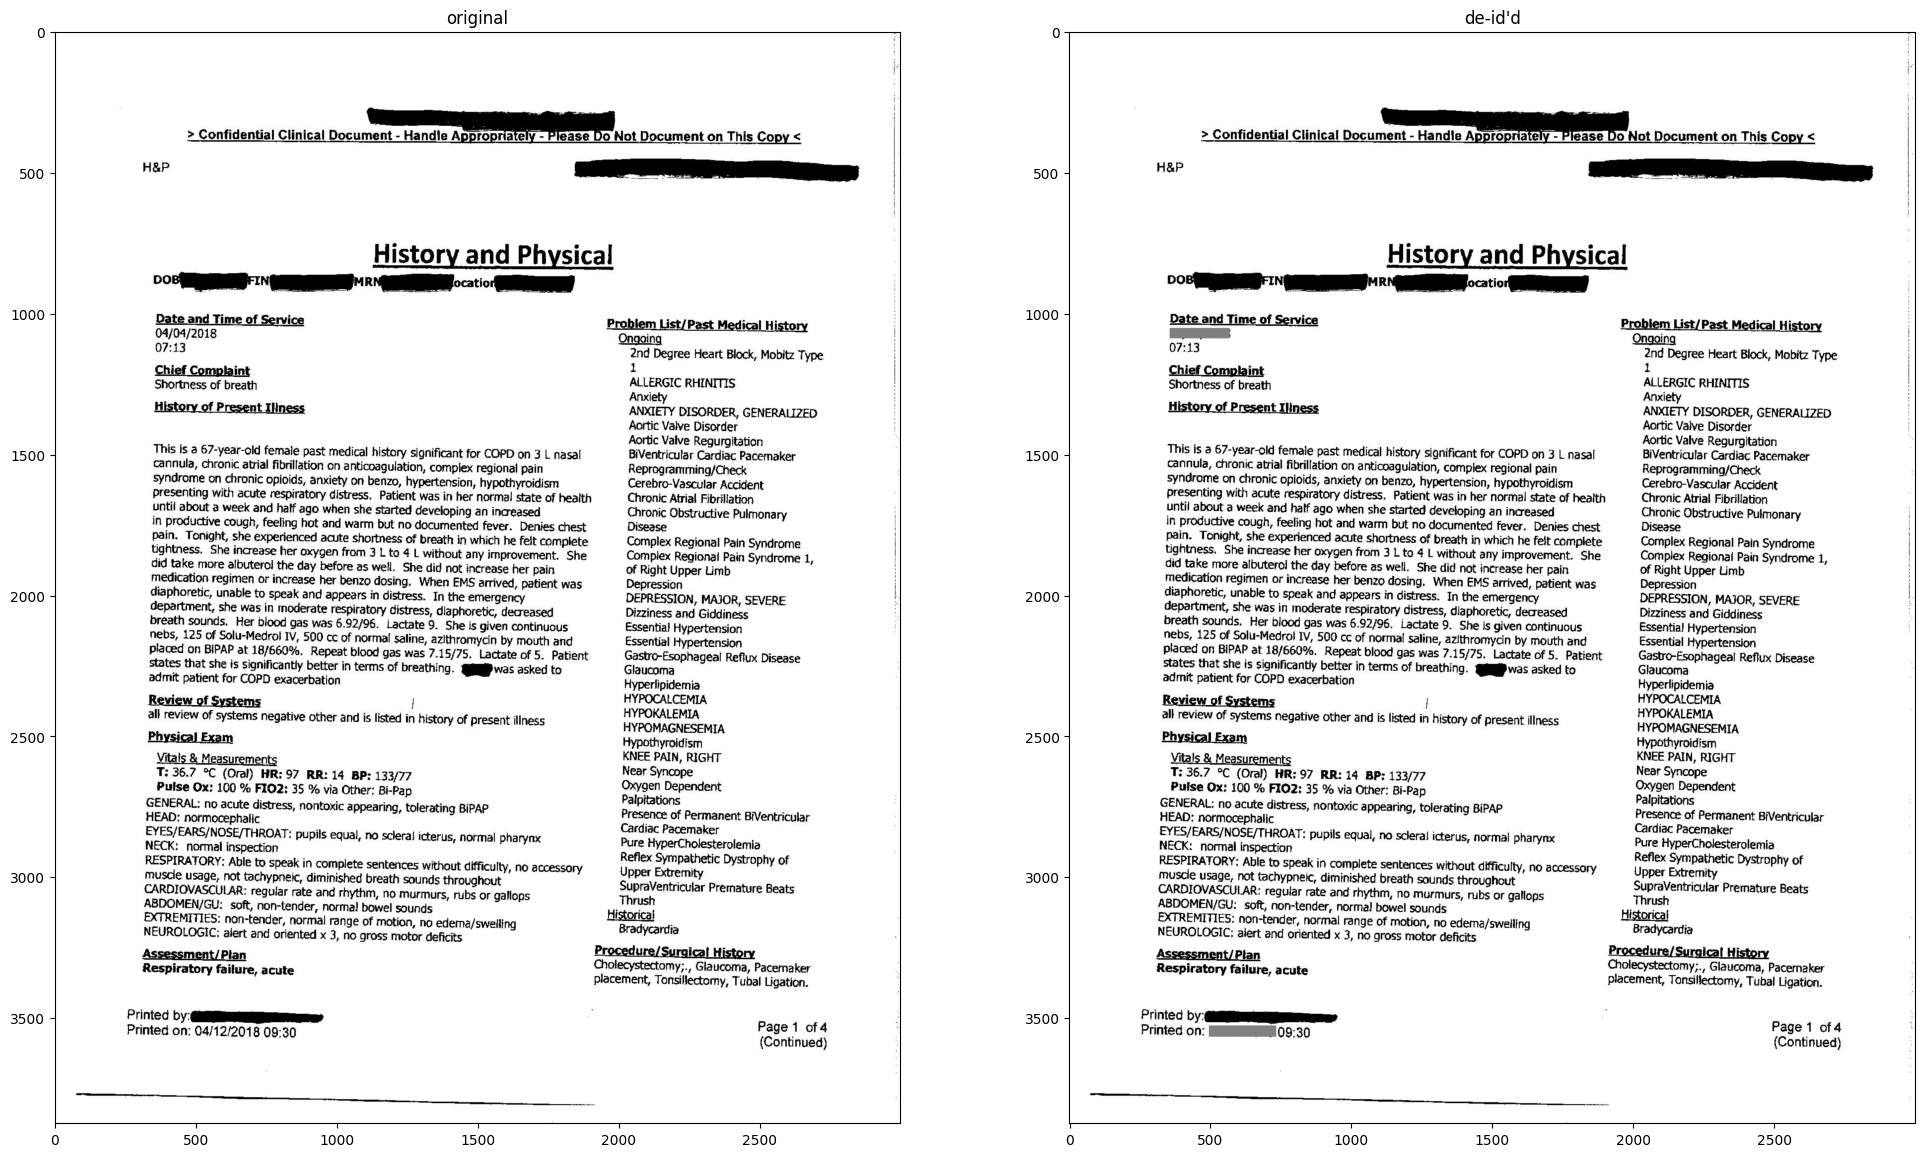

In [ ]:
# NBVAL_SKIP
for r in result.select("image_raw", "image_with_regions").collect():
    img_orig = r.image_raw
    img_deid = r.image_with_regions

    img_pil_orig = visual.to_pil_image(img_orig, img_orig.mode)
    img_pil_deid = visual.to_pil_image(img_deid, img_deid.mode)

    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil_orig, cmap='gray')
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pil_deid, cmap='gray')
    plt.title("de-id'd")
    plt.show()

## Store result

In [ ]:
# NBVAL_SKIP
import os
output_path = "././data/images/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in result.select("image_with_regions", "path").collect():
    path, name = os.path.split(r.path)
    file_name = os.path.join(output_path, name)
    print(f"Storing to {file_name}")

    im = visual.to_pil_image(r.image_with_regions, r.image_with_regions.mode)
    im.save(file_name)

Storing to ././data/images/deidentified/p1.jpg


## Remove results

In [ ]:
%%bash
rm -r -f ././data/images/deidentified